### Imports


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
from joblib import Parallel, delayed # Run functions in parallel
# import scipy as sc # 
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
from enum import Enum


c:\users\george\anaconda3\envs\tensor_cuda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\george\anaconda3\envs\tensor_cuda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\users\george\anaconda3\envs\tensor_cuda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Global variables

In [2]:
data_dir = '../dataset/optiver-realized-volatility-prediction/'

use_GPU = True

warnings.filterwarnings('ignore')
# pd.set_option('max_columns', 300)


### Functional Variables

In [3]:
buckets_count = 30
max_seconds_in_bucket = 600  # each observation in range 0-600 (seconds)

buckets = np.linspace(0, max_seconds_in_bucket, buckets_count, dtype=int) #  List used for binning (used as a name:lower bound of group) 
buckets = buckets[:-1]

output_dir = 'run_results/'
test_id = '1st_attempt_raw_data' + str(buckets_count)
test_dir = output_dir+test_id+"/"


### Helper Functions

In [4]:
# wap of 1st entry in book
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1']+ df['ask_size1'])
    return wap

# wap of 2nd entry in book
def calc_wap2(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def unique_count(series):
    return len(np.unique(series))

# Root mean squared percentage error for early stoping
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

# Create the row_id column to merge data with
def read_main_csvs():
    train = pd.read_csv(data_dir + 'train.csv')
    test = pd.read_csv(data_dir + 'test.csv')
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'The training set has {train.shape[0]} rows')
    return train, test

# Create features for order book data (for a given stock file)
def create_bucketed_features(dataframe, aggregate_features_map):
    features = pd.DataFrame()

    for bucket_start_time in buckets:
        # Group into time buckets
        bucketed_features = dataframe[dataframe['seconds_in_bucket']
                                    .between(bucket_start_time, bucket_start_time + buckets[1] - buckets[0])].groupby(['time_id'])                            .agg(aggregate_features_map)
        bucketed_features.columns = ['_'.join(col) for col in bucketed_features.columns]
        bucketed_features = bucketed_features.add_suffix('_' + str(bucket_start_time))
        if bucket_start_time == 0:
            features = bucketed_features
        else:
            features = features.merge(bucketed_features, how = 'outer', left_on = 'time_id', right_on = 'time_id')
    
    return features

def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df

def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

def plot_importance(importance_fig, filename):
    if not os.path.exists(os.path.dirname(test_dir)):
        try:
            os.makedirs(os.path.dirname(test_dir))
        except:
            print("Could not create dir",filename)
    timestamp = datetime.datetime.now().strftime('%m-%d-%H_%M')
    importance_fig.figure.savefig(test_dir+filename+timestamp+"plot"+".png")
    
    
def save_results_to_file(filename,params,rmspe_score):
    if not os.path.exists(os.path.dirname(test_dir)):
        try:
            os.makedirs(os.path.dirname(test_dir))
        except:
            print("Could not create dir")
    timestamp = datetime.datetime.now().strftime('%m-%d-%H_%M')
    with open(test_dir+filename+timestamp+'.txt', 'w') as f:
        f.write(f'The test RMSPE is {rmspe_score} \n Hyperparams: {params}')



### Raw data processing

In [5]:
# Split into time buckets within a time_id
def group_order_book_in_time_buckets(file_path):
    dataframe = pd.read_parquet(file_path)
        
    aggregate_features_map = {
        'bid_price1': [np.mean],
        'ask_price1': [np.mean],
        
        'bid_price2': [np.mean],
        'ask_price2': [np.mean],
        
        'bid_size1': [np.mean],
        'ask_size1': [np.mean],
        
        'bid_size2': [np.mean],
        'ask_size2': [np.mean],
    }
    
        
    features = create_bucketed_features(dataframe,aggregate_features_map)
    features = features.reset_index(level=0)
    
    stock_id = file_path.split('=')[1]
    features['row_id'] = features['time_id'].apply(lambda x: f'{stock_id}-{x}')
    
    features.drop(['time_id'], axis = 1, inplace = True)
    return features

# Split into time buckets within a time_id
def group_trade_book_in_time_buckets(file_path):
    dataframe = pd.read_parquet(file_path)

    aggregate_features_map = {
        'price':[np.mean],
        'size':[np.mean],
        'order_count':[np.mean],
    }


    features = create_bucketed_features(dataframe,aggregate_features_map)
    features = features.reset_index(level=0)
    
  
    features = features.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    features['row_id'] = features['trade_time_id'].apply(lambda x: f'{stock_id}-{x}')
    features.drop(['trade_time_id'], axis = 1, inplace = True)
    return features


In [6]:
def load_stock(stock_id,is_training_set):
    # Train
    if is_training_set:
        order_book_path = f"{data_dir}book_train.parquet/stock_id={str(stock_id)}"
        trade_book_path = f"{data_dir}trade_train.parquet/stock_id={str(stock_id)}"
    # Test
    else:
        order_book_path = f"{data_dir}book_test.parquet/stock_id={str(stock_id)}"
        trade_book_path = f"{data_dir}trade_test.parquet/stock_id={str(stock_id)}"
    # Create order and trade book features and merge them
    processed_order_book = group_order_book_in_time_buckets(order_book_path)
    processed_trade_book = group_trade_book_in_time_buckets(trade_book_path)

    _tmp = pd.merge(processed_order_book, processed_trade_book, on = ['row_id'], how = 'left')
    return _tmp
    

In [7]:
%%time
train, test = read_main_csvs()

# Features engineering & binning for training set
train_stock_ids = train['stock_id'].unique()
dataframes = None
dataframes = Parallel(n_jobs = -1, verbose = 1)(delayed(load_stock)(stock_id,is_training_set=True) for stock_id in train_stock_ids)

train_ = pd.concat(dataframes, ignore_index = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Features engineering & binning for test set
test_stock_ids = test['stock_id'].unique()
print(test_stock_ids)
dataframes = None
dataframes = Parallel(n_jobs = -1, verbose = 1)(delayed(load_stock)(stock_id,is_training_set=False) for stock_id in test_stock_ids)

test_ = pd.concat(dataframes, ignore_index = True)
test = test.merge(test_, on = ['row_id'], how = 'left')   

The training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   26.7s finished


[0]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


CPU times: total: 22 s
Wall time: 48.4 s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [8]:
len(train.index)

428932

In [9]:
train.head()

,stock_id,time_id,target,row_id,bid_price1_mean_0,ask_price1_mean_0,bid_price2_mean_0,ask_price2_mean_0,bid_size1_mean_0,ask_size1_mean_0,...,trade_order_count_mean_517,trade_price_mean_537,trade_size_mean_537,trade_order_count_mean_537,trade_price_mean_558,trade_size_mean_558,trade_order_count_mean_558,trade_price_mean_579,trade_size_mean_579,trade_order_count_mean_579
0,0,5,0.004136,0-5,1.001422,1.002301,1.001370,1.002397,3.000000,125.692308,...,1.0,1.003008,43.250000,2.500000,1.002953,250.0,3.5,1.003562,17.0,2.5
1,0,11,0.001445,0-11,0.999473,1.000176,0.999423,1.000376,201.250000,100.000000,...,1.0,1.000818,12.333333,1.666667,1.000627,206.0,6.0,NaN,NaN,NaN
2,0,16,0.002168,0-16,0.999662,1.000556,0.999572,1.000763,100.777778,90.666667,...,6.0,0.997542,246.000000,3.000000,NaN,NaN,NaN,0.997535,105.5,2.5
3,0,31,0.002195,0-31,0.999815,1.000478,0.999753,1.000540,343.000000,114.000000,...,NaN,0.998011,59.000000,2.000000,0.997972,450.0,8.0,NaN,NaN,NaN
4,0,62,0.001747,0-62,0.999744,1.000132,0.999495,1.000225,46.833333,6.500000,...,NaN,0.999417,1.000000,1.000000,NaN,NaN,NaN,0.999749,34.0,10.0


In [10]:
test.head()

,stock_id,time_id,row_id,bid_price1_mean_0,ask_price1_mean_0,bid_price2_mean_0,ask_price2_mean_0,bid_size1_mean_0,ask_size1_mean_0,bid_size2_mean_0,...,trade_order_count_mean_517,trade_price_mean_537,trade_size_mean_537,trade_order_count_mean_537,trade_price_mean_558,trade_size_mean_558,trade_order_count_mean_558,trade_price_mean_579,trade_size_mean_579,trade_order_count_mean_579
0,0,4,0-4,1.000049,1.000606,0.999656,1.000721,157.333333,73.333333,100.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
train.columns

Index(['stock_id', 'time_id', 'target', 'row_id', 'bid_price1_mean_0',
       'ask_price1_mean_0', 'bid_price2_mean_0', 'ask_price2_mean_0',
       'bid_size1_mean_0', 'ask_size1_mean_0',
       ...
       'trade_order_count_mean_517', 'trade_price_mean_537',
       'trade_size_mean_537', 'trade_order_count_mean_537',
       'trade_price_mean_558', 'trade_size_mean_558',
       'trade_order_count_mean_558', 'trade_price_mean_579',
       'trade_size_mean_579', 'trade_order_count_mean_579'],
      dtype='object', length=323)

In [12]:
train = train.drop(['time_id'], axis = 1)
test = test.drop(['time_id'], axis = 1)

In [13]:
def train_and_evaluate(train, test):
    # Hyperparammeters (just basic)
    
    hyperparameters = {
        'objective': 'rmse',  
        'boosting_type': 'gbdt',
        #'boosting_type': 'dart',          # Try to solve over-specialization problem in gbdt
        #'boosting_type': 'goss',          # Goss provides a new sampling method for GBDT by separating those instances with larger gradients.
        'num_iterations': 5678,            # Num_iterations specifies the number of boosting iterations (trees to build). The more trees you build the more accurate your model can be at the cost of:
        'n_estimators': 10000,             # controls the number of decision trees 
        'min_data_in_leaf': 9,
        'max_bin': 75,                     # If you define max_bin 255 that means we can have a maximum of 255 unique values per feature. Then Small max_bin causes faster speed and large value improves accuracy.
        'num_leaves': 27,
        'max_depth': 9,                    # This parameter control max depth of each trained tree and will have impact on:       The best value for the num_leaves parameter     Model Performance Training Time  Pay attention If you use a large value of max_depth, your model will likely be over fit  to the train set
        'n_jobs': -1,
        'learning_rate': 0.095,            # learning_rate > 0.0 Typical: 0.05.
        'feature_fraction': 0.9,           # or sub_feature deals with column sampling, LightGBM will randomly select a subset of features on each iteration (tree)
        'bagging_fraction': 0.9,           # you can specify the percentage of rows used per tree building iteration.
        'verbose': -1,
    }
    
    if use_GPU:
        hyperparameters.update(
            {'device' : 'gpu',
            'gpu_platform_id' : 0,
            'gpu_device_id' : 0,}
        )
   
    # We need to drop row_id as it contains info from both time_id and stock_id and time id should be out of the features | should only be used in predictions
    x = train.drop(['row_id', 'target'], axis = 1)
    y = train['target']
    x_test = test.drop(['row_id'], axis = 1)

    x['stock_id'] = x['stock_id'].astype(int)
    x_test['stock_id'] = x_test['stock_id'].astype(int)

    
    test_predictions = np.zeros(x_test.shape[0])
    
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])

    
    kfold = KFold(n_splits = 5, random_state = 66, shuffle = True)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = hyperparameters, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 10000, 
                          early_stopping_rounds = 50, 
                          verbose_eval = 50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        test_predictions += model.predict(x_test) / 5
    
    importance_plot = lgb.plot_importance(model,max_num_features=7,figsize=(32,15))
    plot_importance(importance_plot, "feature_importance_plot")
    rmspe_score = rmspe(y, oof_predictions)
    print(f'The out of folds RMSPE is {rmspe_score}')

    return test_predictions

Training fold 1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000679673	training's RMSPE: 0.314795	valid_1's rmse: 0.000692178	valid_1's RMSPE: 0.319395
[100]	training's rmse: 0.000629772	training's RMSPE: 0.291683	valid_1's rmse: 0.000653609	valid_1's RMSPE: 0.301598
[150]	training's rmse: 0.000600229	training's RMSPE: 0.278	valid_1's rmse: 0.000631708	valid_1's RMSPE: 0.291492
[200]	training's rmse: 0.000581328	training's RMSPE: 0.269246	valid_1's rmse: 0.000620093	valid_1's RMSPE: 0.286132
[250]	training's rmse: 0.000566714	training's RMSPE: 0.262478	valid_1's rmse: 0.000611656	valid_1's RMSPE: 0.282239
[300]	training's rmse: 0.000555352	training's RMSPE: 0.257215	valid_1's rmse: 0.000606028	valid_1's RMSPE: 0.279642
[350]	training's rmse: 0.000546397	training's RMSPE: 0.253067	valid_1's rmse: 0.000602407	valid_1's RMSPE: 0.277971
[400]	training's rmse: 0.000538855	training's RMSPE: 0.249574	valid_1's rmse: 0.000599174	valid_1's RMSPE: 0.276479

[550]	training's rmse: 0.000519546	training's RMSPE: 0.240088	valid_1's rmse: 0.000600095	valid_1's RMSPE: 0.279411
[600]	training's rmse: 0.000514268	training's RMSPE: 0.237648	valid_1's rmse: 0.000598864	valid_1's RMSPE: 0.278838
[650]	training's rmse: 0.000509436	training's RMSPE: 0.235416	valid_1's rmse: 0.000599065	valid_1's RMSPE: 0.278931
Early stopping, best iteration is:
[611]	training's rmse: 0.000513143	training's RMSPE: 0.237129	valid_1's rmse: 0.000598589	valid_1's RMSPE: 0.27871
Training fold 5
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000678679	training's RMSPE: 0.314485	valid_1's rmse: 0.00069766	valid_1's RMSPE: 0.321303
[100]	training's rmse: 0.000628035	training's RMSPE: 0.291018	valid_1's rmse: 0.000655954	valid_1's RMSPE: 0.302096
[150]	training's rmse: 0.000599566	training's RMSPE: 0.277826	valid_1's rmse: 0.000634255	valid_1's RMSPE: 0.292102
[200]	training's rmse: 0.000580257	training's RMSPE: 0.268878	valid_1's rmse: 0

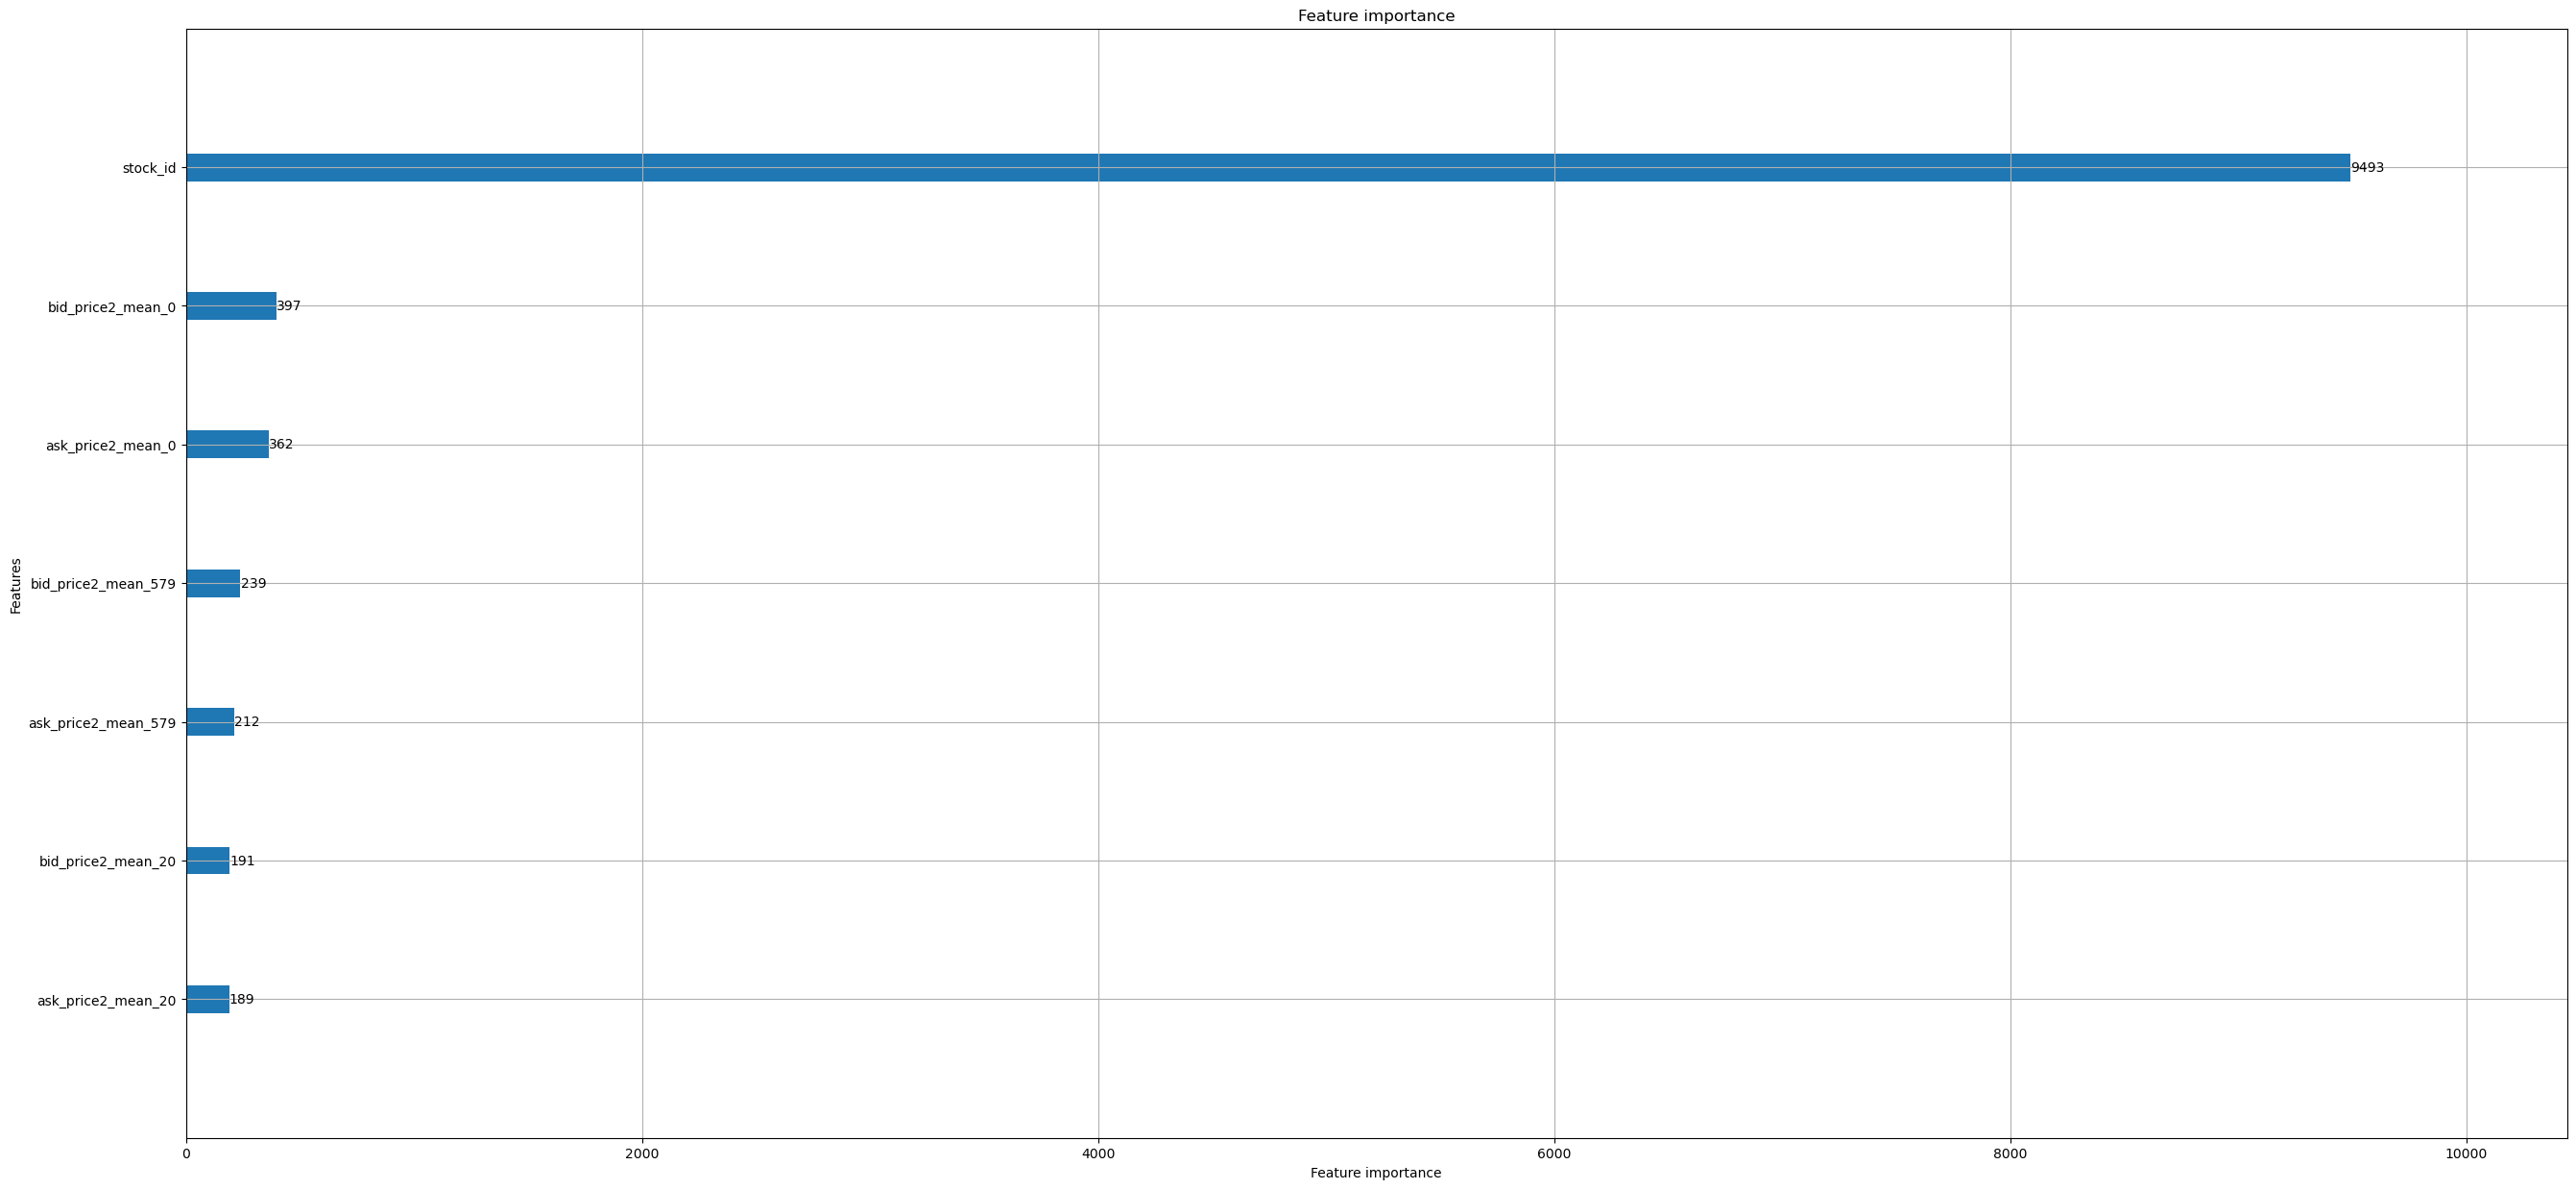

In [14]:
%%time
# Traing and evaluating
test_predictions = train_and_evaluate(train, test)

In [15]:
# Save test predictions for submission
test['target'] = test_predictions
test[['row_id', 'target']].to_csv('submission.csv',index = False)